#The Sprint 8 Supervised Learning Project involves analyzing bank customers data to determine if a customer is going to leave the bank or not.  The bank figured it was cheaper to try and keep existing customers than go out and get new ones.  We are attempting to predict whether a customer is going to leave the bank soon.

#To begin I will import the modules and check the data for missing information, outliers or invalid info.  From there I will begin using different models to try and create a good F1 Score.

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv('/datasets/Churn.csv')
data_nan = pd.isna(data)
print(data_nan.sum())
print(data.describe())

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64
         RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  9091.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800     4.997690   
std     2886.89568  7.193619e+04     96.653299     10.487806     2.894723   
min        1.00000  1.556570e+07    350.000000     18.000000     0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000     2.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000     5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000     7.000000   
max    10000.00000  1.581569e+07    850.000000   

#Since there is a large amount of NaN values in the tenure column I am going to change the NaN values to the mean of the column instead of deleting them to help with the modeling.

In [2]:
data['Tenure'].fillna(data['Tenure'].mean(), inplace=True)
data_nan = pd.isna(data)
print(data_nan.sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


#Starting out I am importing all the possible python packages we will be needing to use to study the dataset along with importing the data from the csv into a dataframe.  Next I will breaking the data into the target and features dataframes to seperate them for a target dataset.  Then from there breaking them down further to get the training, validation and test datasets.

In [3]:
target = data['Exited']
features = data.drop(['Exited', 'Surname', 'CustomerId'], axis=1)
categorical_features = ["Geography", "Gender"]
categorical_features = [col for col in categorical_features if col in features.columns]
numerical_features = [col for col in features.columns if col not in categorical_features]
features = pd.get_dummies(features, drop_first=True)

features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features)], remainder='passthrough'  # Scale numerical features  
)

features_train = preprocessor.fit_transform(features_train)
features_valid = preprocessor.transform(features_valid)
features_test = preprocessor.transform(features_test)


#Now I am going to begin testing different models on the data to see which ones have the best scores.  I will be starting out with the Decision Tree Classifier model and I will have hyperparameters on it to see which depth and min samples give me the best F1 and AUC score.

In [4]:
max_depth_values_dtc = [3, 6, 10, None] 
min_samples_split_values_dtc = [2, 3, 4, 5]
best_score_dtc = 0
best_params_dtc = {}

for max_depth in max_depth_values_dtc:
    for min_samples_split in min_samples_split_values_dtc:
        model_dtc = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=12345)
        model_dtc.fit(features_train, target_train)
        predicted_valid_dtc = model_dtc.predict(features_valid)
        f1_dtc = f1_score(target_valid, predicted_valid_dtc)
        auc_roc_dtc = roc_auc_score(target_valid, predicted_valid_dtc)
        if f1_dtc > best_score_dtc:
            best_score_dtc = f1_dtc
            best_params_dtc = {"max_depth": max_depth, "min_samples_split": min_samples_split}

print("Best Decision Tree Classifier Hyperparameters:", best_params_dtc)
print("Best Decision Tree Classifier F1 Score:", best_score_dtc)
print("Decision Tree Classifier AUC ROC Score:", auc_roc_dtc)

Best Decision Tree Classifier Hyperparameters: {'max_depth': 6, 'min_samples_split': 5}
Best Decision Tree Classifier F1 Score: 0.5696969696969697
Decision Tree Classifier AUC ROC Score: 0.685660752847525


#From my findings the decision tree classifier model did not achieve of the F1 score requirement of 0.57.  We tuned hyperparameters and it still did not score high enough.  We are going to try different models and oversampling/undersampling to improve the models.

In [5]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_valid_lr = model_lr.predict(features_valid)
f1_lr = f1_score(target_valid, predicted_valid_lr)
auc_roc_lr = roc_auc_score(target_valid, predicted_valid_lr)

print("Best Logistic Regression F1 Score:", f1_lr)
print("Logistic Regression AUC ROC Score:", auc_roc_lr)

Best Logistic Regression F1 Score: 0.3350253807106599
Logistic Regression AUC ROC Score: 0.5950329363231087


#Because we have extreme class imbalance the model is predicting an extremely low F1 score of 0.34 because there are far more 0s in the data than 1s for the 'Exited' variable.   To adjust for the class imbalance and the poor model we are going to encode the categorical variables (Geography and Gender).  Then we will scale Credit Score, Age and Estimated Salary to normalize the continuous variables.  From there we will use oversampling to help balance the classes.

#I deleted the second logistic regression model because it had the scaler and split the data again.  I just moved the scaler to the top before I split the data then reran the models.

In [6]:
best_est = 0
best_depth = 0
min_samples_split_values = [4, 6, 8, 10]
min_samples_leaf_values = [1, 2, 4]
best_score_rfc = 0
best_params_rfc = {}


for est in range(10, 20):  
    for depth in range(10, 15, 20):
            for min_samples_split in min_samples_split_values:
                model_rfc = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=min_samples_split, class_weight="balanced", random_state=12345)  
                model_rfc.fit(features_train, target_train)
                predicted_valid_rfc = model_rfc.predict(features_valid)
                f1_rfc = f1_score(target_valid, predicted_valid_rfc)
                auc_roc_rfc = roc_auc_score(target_valid, model_rfc.predict_proba(features_valid)[:, 1])
            
                if f1_rfc > best_score_rfc:
                    best_score_rfc = f1_rfc
                    best_params_rfc = {"best_depth": depth, "best_estimators": est, "best min samples split": min_samples_split}

print("Best Random Forest Classifier Hyperparameters:", best_params_rfc) 
print("Best Random Forest Classifier F1 Score:", best_score_rfc)
print("Random Forest Classifier AUC ROC Score:", auc_roc_rfc)

Best Random Forest Classifier Hyperparameters: {'best_depth': 10, 'best_estimators': 13, 'best min samples split': 10}
Best Random Forest Classifier F1 Score: 0.6116279069767442
Random Forest Classifier AUC ROC Score: 0.8448272733321637


#After scaling the credit score, age and salary then changing categorical variables to numbers while also adding estimators, depth, min samples split and min samples leaf I got a F1 score of 0.61.  Adding the additional parameters helped and also provided me with an AUC ROC of 0.845.

Class Counts: 0    7963
1    2037
Name: Exited, dtype: int64
Class Percentages: 0    79.63
1    20.37
Name: Exited, dtype: float64


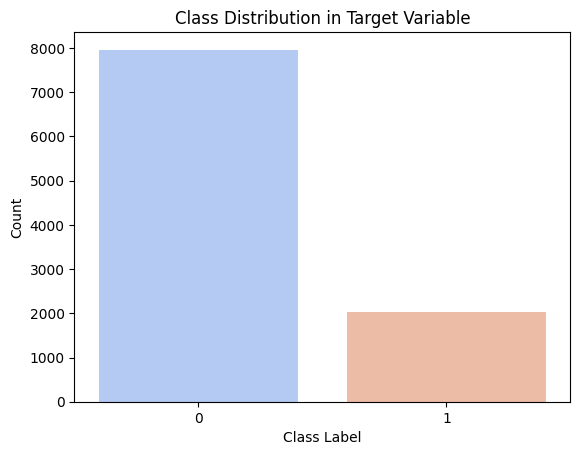

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = data['Exited'].value_counts()
class_percentages = data['Exited'].value_counts(normalize=True) * 100

print("Class Counts:", class_counts)
print("Class Percentages:", class_percentages)

plt.figure()
sns.countplot(x=data['Exited'], palette="coolwarm")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution in Target Variable")
plt.show()

#Looking into the data we realize there is imbalance in our information.  We need to upsample the 1s (or the exited) variables to help get balance for our models.

In [9]:
features_train = pd.DataFrame(features_train, columns=features.columns)

def upsample(features, target, repeat):
    features = pd.DataFrame(features, columns=features.columns)
    target = pd.Series(target, index=features.index) 

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model_upsample = LogisticRegression(random_state=12345, solver='liblinear')
model_upsample.fit(features_upsampled, target_upsampled)

predicted_valid_upsample = model_upsample.predict(features_valid)

f1_upsample = f1_score(target_valid, predicted_valid_upsample)

print("F1 Score after Upsampling:", f1_upsample)
print(features_upsampled.describe())
print(target_upsampled.describe())
print(features_upsampled.head(10))
print(target_upsampled.head(10))

F1 Score after Upsampling: 0.34425176621708414
         RowNumber  CreditScore          Age       Tenure      Balance  \
count  5879.000000  5879.000000  5879.000000  5879.000000  5879.000000   
mean      0.014500    -0.002944    -0.013660    -0.008653     0.005299   
std       0.995805     0.985473     0.982689     0.987913     1.001109   
min      -1.722633    -3.140255    -1.986549    -1.829601    -1.233163   
25%      -0.839357    -0.699824    -0.657902    -0.737618    -1.233163   
50%       0.013436    -0.004041    -0.183385    -0.009629     0.327503   
75%       0.869520     0.670972     0.386035     0.718360     0.825085   
max       1.740845     2.052152     5.036300     1.810342     2.345224   

       NumOfProducts    HasCrCard  IsActiveMember  EstimatedSalary  \
count    5879.000000  5879.000000     5879.000000      5879.000000   
mean       -0.021479    -0.003498       -0.040287         0.007581   
std         1.001674     1.001676        1.001438         0.998760   
min   

#I upsampled the data and got an F1 that was even worse.  I believe this is because the logistic regression model does not do a good job of predicting with this data.  The F1 is no where near 0.59 and is at 0.34, very poor performance.  Next I am going to try to do the random forest classifier again but with updated hyperparamters, including additional ones along with upsampling the data.

In [10]:
best_est = 0
best_depth = 0
min_samples_split_values = [6, 8, 10]
min_samples_leaf_values = [1, 2, 4]
best_score_upsample = 0
best_params_upsample = {}

for est in range(10, 40, 10):  
    for depth in range(10, 15):
        for min_samples_leaf in min_samples_leaf_values:
            for min_samples_split in min_samples_split_values:
                model_upsample = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=min_samples_split, random_state=12345)  
                model_upsample.fit(features_upsampled, target_upsampled)
                predicted_valid_upsample = model_upsample.predict(features_valid)
                f1_upsample = f1_score(target_valid, predicted_valid_upsample)
                auc_roc_upsample = roc_auc_score(target_valid, model_upsample.predict_proba(features_valid)[:, 1])
            
                if f1_upsample > best_score_upsample:
                    best_score_upsample = f1_upsample
                    best_params_upsample = {"best_depth": depth, "best_estimators": est, "best min samples split": min_samples_split, "best min samples leaf": min_samples_leaf}

print("Best Random Forest Classifier Hyperparameters:", best_params_rfc)
print("Best Random Forest Classifier F1 Score:", best_score_upsample)
print("Random Forest Classifier AUC ROC Score:", auc_roc_upsample)

Best Random Forest Classifier Hyperparameters: {'best_depth': 10, 'best_estimators': 13, 'best min samples split': 10}
Best Random Forest Classifier F1 Score: 0.2845927379784102
Random Forest Classifier AUC ROC Score: 0.4809202209062479


#After upsampling the data and running the random forest classifier with the new data and the additional hyperparameters I still got a bad F1 score of 0.28.  How I dealt with class imbalances in the project was turning the categorical variables like geography and gender into numerical variables.  I also scaled the data for salary, age and balance as well.  I used an additional method of upsampling the data as well to make the data more balanced.  I used the 4 for repeat since according to the data above there were 8,000 zeros and 2,000 1s so I multiplied the 2,000 by 4 to get the numbers even.  Overall the model ended up getting an F1 score of 0.28 and an AUC ROC score of 0.48 which is a very poor performing mode.

In [11]:
def downsample(features, target, fraction):
    features = pd.DataFrame(features, columns=features.columns)
    target = pd.Series(target, index=features.index) 

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

best_est = 0
best_depth = 0
min_samples_split_values = [6, 8, 10]
min_samples_leaf_values = [1, 2, 4]
best_score_downsample = 0
best_params_downsample = {}

for est in range(10, 40, 10):  
    for depth in range(10, 15):
        for min_samples_leaf in min_samples_leaf_values:
            for min_samples_split in min_samples_split_values:
                model_downsample = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=min_samples_split, random_state=12345)  
                model_downsample.fit(features_downsampled, target_downsampled)
                predicted_valid_downsample = model_downsample.predict(features_valid)
                f1_downsample = f1_score(target_valid, predicted_valid_downsample)
                auc_roc_downsample = roc_auc_score(target_valid, model_downsample.predict_proba(features_valid)[:, 1])
            
                if f1_downsample > best_score_downsample:
                    best_score_downsample = f1_downsample
                    best_params_downsample = {"best_depth": depth, "best_estimators": est, "best min samples split": min_samples_split, "best min samples leaf": min_samples_leaf}
                                   
print("Best Random Forest Classifier Hyperparameters:", best_params_rfc)
print("Best Random Forest Classifier F1 Score:", best_score_downsample)
print("Random Forest Classifier AUC ROC Score:", auc_roc_downsample)

Best Random Forest Classifier Hyperparameters: {'best_depth': 10, 'best_estimators': 13, 'best min samples split': 10}
Best Random Forest Classifier F1 Score: 0.3352750809061488
Random Forest Classifier AUC ROC Score: 0.5040058916397994


#I down sampled the data now to help with imbalance.  The downsampled got us a worse F1 and AUC ROC score, which makes sense because it is looking at less data so the model would be less accurate.  I used 0.25 for my fraction to get the 8,000 value to 2,000.

#Now I am going to run my two best models on the testing data to see which one performs the best.  First I will run it on the original random forest model that did not have any down or upsampling and contained some hyperparameters.  In the original model run it had an F1 of 0.59 and an AUC ROC of 0.84.

In [12]:
features_valid = pd.DataFrame(features_valid, columns=features.columns)
print(features_train.head(5))
print(target_train.head(5))


   RowNumber  CreditScore       Age    Tenure   Balance  NumOfProducts  \
0   0.867962    -0.886751 -0.373192  1.082354  1.232271      -0.891560   
1  -0.541122     0.608663 -0.183385  1.082354  0.600563      -0.891560   
2   0.365014     2.052152  0.480939 -0.737618  1.027098       0.830152   
3  -1.290694    -1.457915 -1.417129  0.354365 -1.233163       0.830152   
4  -0.435475     0.130961 -1.132419 -1.101612  1.140475      -0.891560   

   HasCrCard  IsActiveMember  EstimatedSalary  Geography_Germany  \
0   0.642466       -1.055187        -0.187705                0.0   
1  -1.556504       -1.055187        -0.333945                0.0   
2  -1.556504        0.947699         1.503095                1.0   
3   0.642466       -1.055187        -1.071061                0.0   
4  -1.556504       -1.055187         1.524268                1.0   

   Geography_Spain  Gender_Male  
0              1.0          1.0  
1              0.0          0.0  
2              0.0          1.0  
3         

In [13]:
best_est = 0
best_depth = 0
min_samples_split_values = [6, 8, 10]
min_samples_leaf_values = [1, 2, 4]
best_score_rfc_test = 0
best_params_rfc_test = {}

for est in range(10, 40, 10):  
    for depth in range(10, 15):
        for min_samples_leaf in min_samples_leaf_values:
            for min_samples_split in min_samples_split_values:
                model_rfc_test = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=min_samples_split, random_state=12345)  
                model_rfc_test.fit(features_train, target_train)
                predicted_rfc_test = model_rfc_test.predict(features_valid)
                f1_rfc_test = f1_score(target_valid, predicted_rfc_test)
                auc_roc_rfc_test = roc_auc_score(target_valid, model_rfc_test.predict_proba(features_valid)[:, 1])
            
                if f1_rfc > best_score_rfc_test:
                    best_score_rfc_test = f1_rfc_test
                    best_params_rfc_test = {"best_depth": depth, "best_estimators": est, "best min samples split": min_samples_split, "best min samples leaf": min_samples_leaf}

print("Best Random Forest Classifier Hyperparameters:", best_params_rfc_test)
print("Best Random Forest Classifier F1 Score:", best_score_rfc_test)
print("Random Forest Classifier AUC ROC Score:", auc_roc_rfc_test)

Best Random Forest Classifier Hyperparameters: {'best_depth': 14, 'best_estimators': 30, 'best min samples split': 10, 'best min samples leaf': 4}
Best Random Forest Classifier F1 Score: 0.5591397849462365
Random Forest Classifier AUC ROC Score: 0.839493645618471


#On the test data set the F1 score fell slightly from 0.59 to 0.57, performing just slightly worse on the test data.  Next I am going to run the test set on the random forest classifier model with the upsampled data since that is the model that performed the best originally on the dataset.

In [14]:
best_est = 0
best_depth = 0
min_samples_split_values = [6, 8, 10]
min_samples_leaf_values = [1, 2, 4]
best_score_upsample_test = 0
best_params_upsample_test = {}

for est in range(10, 40, 10):  
    for depth in range(10, 15):
        for min_samples_leaf in min_samples_leaf_values:
            for min_samples_split in min_samples_split_values:
                model_upsample_test = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=min_samples_split, random_state=12345)  
                model_upsample_test.fit(features_train, target_train)
                predicted_test_upsample = model_upsample_test.predict(features_valid)
                f1_upsample_test = f1_score(target_valid, predicted_test_upsample)
                auc_roc_upsample_test = roc_auc_score(target_valid, model_upsample_test.predict_proba(features_valid)[:, 1])
            
                if f1_upsample_test > best_score_upsample_test:
                    best_score_upsample_test = f1_upsample_test
                    best_params_upsample_test = {"best_depth": depth, "best_estimators": est, "best min samples split": min_samples_split, "best min samples leaf": min_samples_leaf}

print("Best Random Forest Classifier Hyperparameters:", best_params_rfc_test)
print("Best Random Forest Classifier F1 Score:", best_score_upsample_test)
print("Random Forest Classifier AUC ROC Score:", auc_roc_upsample_test)

Best Random Forest Classifier Hyperparameters: {'best_depth': 14, 'best_estimators': 30, 'best min samples split': 10, 'best min samples leaf': 4}
Best Random Forest Classifier F1 Score: 0.5925925925925927
Random Forest Classifier AUC ROC Score: 0.839493645618471


#The upsampled model predicted better than the random forest classifier model that wasnt upsampled.  We got an F1score above 0.59 on the test data and 0.62 on the other data.  This model performed the best out of all of them so I would use this one.

In [15]:
model_rfc = RandomForestClassifier(n_estimators=13, max_depth=10, min_samples_split=10, class_weight="balanced", random_state=12345)  
model_rfc.fit(features_train, target_train)
predicted_test_rfc = model_rfc.predict(features_test)
f1_rfc_test = f1_score(target_test, predicted_test_rfc)
auc_roc_rfc_test = roc_auc_score(target_test, model_rfc.predict_proba(features_test)[:, 1])
                 
print("Best Random Forest Classifier F1 Score:", f1_rfc_test)
print("Random Forest Classifier AUC ROC Score:", auc_roc_rfc_test)

Best Random Forest Classifier F1 Score: 0.6077981651376148
Random Forest Classifier AUC ROC Score: 0.847438278683978


#Running the model on the test set gave us a worse F1 score and AUCROC score than before but it is still above the threshold of 0.59.  Adding class weight balanced to the parameters in the random forest classifier helped improve the model.